# Single-qubit gate calibration

In this lab, we go through the different steps of calibrating high-fidelity single-qubit gates for superconducting qubits. We start by calibrating a $\pi$-pulse about the $X$-axis of the Bloch sphere, and use the optimal parameters to construct the $X$, $Y$, and $H$ gates.

### 0. Getting Started

First, we need to import the Qiskit Pulse packages we need.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
from qiskit.visualization.pulse_v2 import draw, IQXDebugging
from qiskit.tools.monitor import job_monitor

from qiskit import pulse            # This is where we access all of our Pulse features!
from qiskit.pulse import Play, Acquire
import qiskit.pulse.library as pulse_lib

from scipy.signal import savgol_filter
from scipy.optimize import curve_fit


# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

Here we define helper functions that we will use throughout this notebook

In [2]:
def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)

def process_reflective_measurement(freqs,values):
    phase_grad = np.gradient(savgol_filter(np.unwrap(np.angle(values)),5,3),freqs)
    #phase_grad = np.gradient(np.unwrap(np.angle(values)),freqs)
    return (phase_grad-min(phase_grad))/(max(phase_grad)-min(phase_grad)) - 1

def f_sine(t, fs, a, offs, ph):
    return a*np.sin(2*np.pi*fs*t+ph)+offs

def fit_rabi(x, y):
    p0=[1/np.median(x)/2 , np.max(y), np.min(y), np.pi/2]
    return curve_fit(f_sine, x, y, p0=p0)

For this lab we will use the ***ibmq_armonk*** backend, which is capable of pulse-level control. The time unit of our pulse control is set by the resolution of analog waveform generators that are used to operator the backend.

In [3]:
provider = IBMQ.get_provider(hub='ibm-q-internal', group='deployed', project='default')
backend = provider.get_backend('ibmq_armonk')

backend_config = backend.configuration()
#backend_defaults = backend.defaults()
backend.configuration().parametric_pulses = []

inst_sched_map = backend.defaults().instruction_schedule_map

dt=backend_config.dt   # hardware resolution

In [4]:
qubit=0   # qubit used in our experiment

measure = inst_sched_map.get('measure', qubits=backend_config.meas_map[0])

drive_chan = pulse.DriveChannel(qubit)  # microwave drive channel
meas_chan = pulse.MeasureChannel(qubit) # resonator channel
acq_chan = pulse.AcquireChannel(qubit)  # readout signal acquisition channel

### Rabi drive

First, we drive the qubit using a pulse with a fix duration and vary the amplitude of the pulse. As a result, we expect to observe Rabi oscillations. The amplitude of the $\pi$-pulse is equal to half the Rabi oscillation period.

In [8]:
pi_pulse_width=20e-9
pi_pulse_duration = pi_pulse_width * 4

To calibrate a high fidelity gate, we use a [DRAG](https://qiskit.org/documentation/stubs/qiskit.pulse.library.Drag.html) pulse shape. The Derivative Removal by Adiabatic Gate (DRAG) pulse is a standard Gaussian pulse with an additional Gaussian derivative component. It is designed to reduce the frequency spectrum of a normal gaussian pulse near the |1⟩ - |2⟩ transition, reducing the chance of leakage to the |2⟩ state. The DRAG pulse takes in the following arguments:
* **duration**: Pulse length.
* **amp**: The amplitude of the pulse.
* **sigma** A measure of how wide or narrow the Gaussian peak is
* **beta** The DRAG correction amplitude.

To begin, we set the DRAG correction amplitude beta to 0 and tune the amplitude of the pulse.

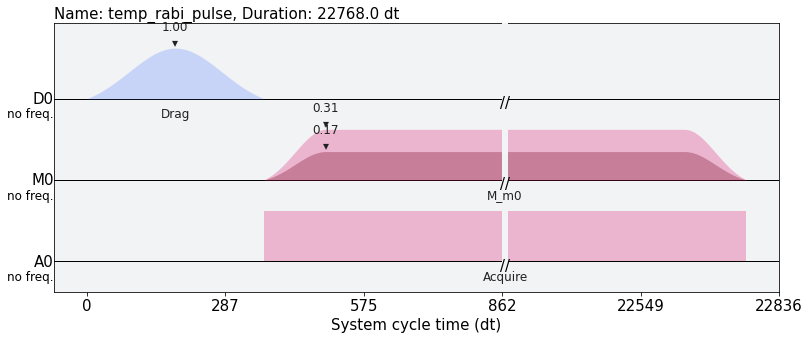

In [9]:
drive_amps=np.linspace(0,1,31)
rabi_pulses=[]
for amp in drive_amps:
    with pulse.build(name='temp_rabi_pulse',backend=backend) as temp_rabi_pulse:
        with pulse.align_sequential():
            pulse.play(pulse.Drag(duration=get_closest_multiple_of_16(pi_pulse_duration//dt), amp=amp, sigma=get_closest_multiple_of_16(pi_pulse_width//dt), beta=0), drive_chan)
            pulse.call(measure)
            
    rabi_pulses.append(temp_rabi_pulse)
    
rabi_pulses[-1].draw(style=IQXDebugging())

In [10]:
num_shots = 1*1024 
rabi_sweep = assemble(rabi_pulses,
                       backend=backend, 
                       meas_level=1,
                       meas_return='avg',
                       shots=num_shots)

In [11]:
job_rabi_sweep = backend.run(rabi_sweep)
job_monitor(job_rabi_sweep)

rabi_sweep_results = job_rabi_sweep.result(timeout=120)

/tmp/ipykernel_94/3603818343.py:1: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  job_rabi_sweep = backend.run(rabi_sweep)


Job Status: job has successfully run


0.7737493287766779

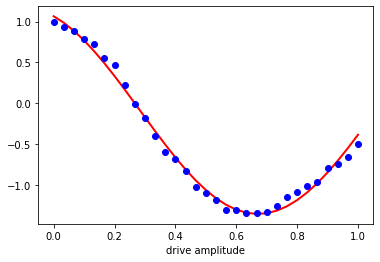

In [12]:
rabi_sweep_values = []
for i in range(len(rabi_sweep_results.results)):
    rabi_sweep_values.append(rabi_sweep_results.get_memory(i)[qubit])

popt, pcov= fit_rabi(drive_amps, np.real(rabi_sweep_values)/ max(np.real(rabi_sweep_values)))

plt.plot(drive_amps, f_sine(drive_amps, *popt),'-', color='red', lw=2)
plt.plot(drive_amps, np.real(rabi_sweep_values)/ max(np.real(rabi_sweep_values)),'o', color='blue', lw=2)

plt.xlabel('drive amplitude')

pi_amp=1/(2*popt[0])
pi_amp

In [13]:
pi_amp=1/(2*popt[0])
pi_amp

0.7737493287766779

### Pulse train

Next, in order to fine-tune the amplitude of our $\pi$-pulse, we apply many of these pulses sequentially to the qubit. This pulse train will amplify the error in calibration, allowing us to extract a more accurate pulse amplitde.

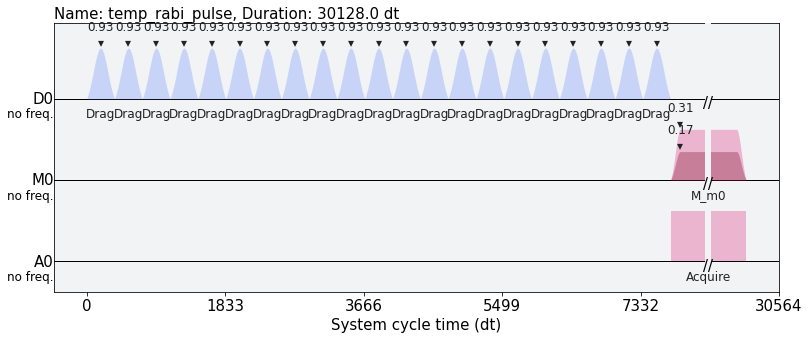

In [14]:
drive_amps=pi_amp * (1 + np.linspace(-0.2, 0.2, 21))
n_pulses= np.arange(1,22,2)
fine_rabi_pulses=[]
for amp in drive_amps:
    for n_pulse in n_pulses:
        with pulse.build(name='temp_rabi_pulse',backend=backend) as temp_rabi_pulse:
            with pulse.align_sequential():
                for _ in range(n_pulse):
                    pulse.play(pulse.Drag(get_closest_multiple_of_16(pi_pulse_duration//dt), amp, sigma=get_closest_multiple_of_16(pi_pulse_width//dt), beta=0), drive_chan)
                pulse.call(measure)

        fine_rabi_pulses.append(temp_rabi_pulse)
    
fine_rabi_pulses[-1].draw(style=IQXDebugging())

In [15]:
num_shots = 1*1024 
fine_rabi_sweep = assemble(fine_rabi_pulses,
                           backend=backend, 
                           meas_level=1,
                           meas_return='avg',
                           shots=num_shots)

In [16]:
job_fine_rabi_sweep = backend.run(fine_rabi_sweep)
job_monitor(job_fine_rabi_sweep)

fine_rabi_sweep_results = job_fine_rabi_sweep.result(timeout=120)

Job Status: job has successfully run


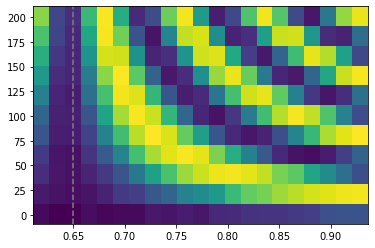

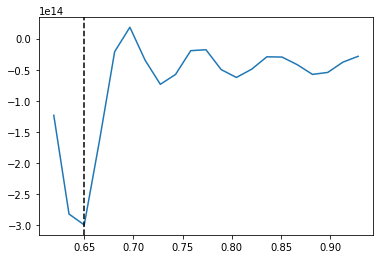

0.6499494361724094

In [31]:
fine_rabi_sweep_values = []
for i in range(len(fine_rabi_sweep_results.results)):
    fine_rabi_sweep_values.append(fine_rabi_sweep_results.get_memory(i)[qubit])

fine_rabi_sweep_values=np.real(fine_rabi_sweep_values)


fine_rabi_sweep_values_reshaped=fine_rabi_sweep_values.reshape(len(drive_amps), len(n_pulses))
pi_amp_fine= drive_amps[np.argmin(np.mean(fine_rabi_sweep_values_reshaped, axis=-1))]

plt.pcolormesh(drive_amps, n_pulses, fine_rabi_sweep_values_reshaped.T)
plt.axvline(x=pi_amp_fine, ls='--', color='grey')
plt.show()

plt.plot(drive_amps, np.mean(fine_rabi_sweep_values_reshaped, axis=-1))
plt.axvline(x=pi_amp_fine, ls='--', color='black')
plt.show()

pi_amp_fine

### Alternating pulse train

The next step in the calibration process is to remove leakage to the higher excited states by tuning the DRAG beta parameter. In order to amplify the leakage error we apply an alternating pulse train to the qubit, where each $\pi$ rotation around the $X$-axis is followed by a $-\pi$ rotation.

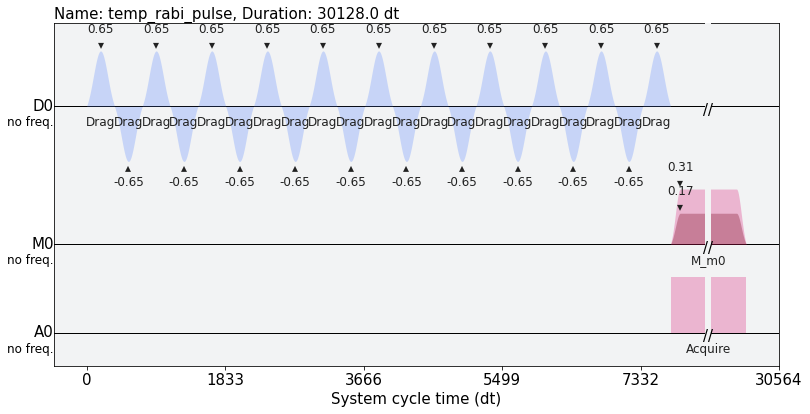

In [26]:
beta_coeffs= np.linspace(0, -3, 21)
n_pulses= np.arange(1,202,20)
drag_calib_pulses=[]
for beta in beta_coeffs:
    for n_pulse in n_pulses:
        with pulse.build(name='temp_rabi_pulse',backend=backend) as temp_rabi_pulse:
            with pulse.align_sequential():
                for n in range(n_pulse):
                    pulse.play(pulse.Drag(get_closest_multiple_of_16(pi_pulse_duration//dt), pi_amp_fine* (-1)**(n%2), sigma=get_closest_multiple_of_16(pi_pulse_width//dt), beta=beta), drive_chan)
                pulse.call(measure)

        drag_calib_pulses.append(temp_rabi_pulse)
    
drag_calib_pulses[1].draw(style=IQXDebugging())

In [27]:
num_shots = 1*1024 
drag_calib_sweep = assemble(drag_calib_pulses,
                           backend=backend, 
                           meas_level=1,
                           meas_return='avg',
                           shots=num_shots)

In [28]:
job_drag_calib_sweep = backend.run(drag_calib_sweep)
job_monitor(job_drag_calib_sweep)

drag_calib_sweep_results = job_drag_calib_sweep.result(timeout=120)

Job Status: job has successfully run


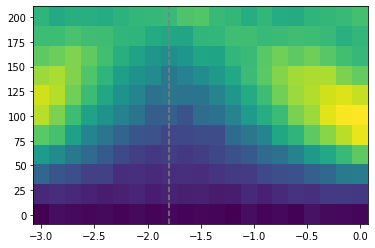

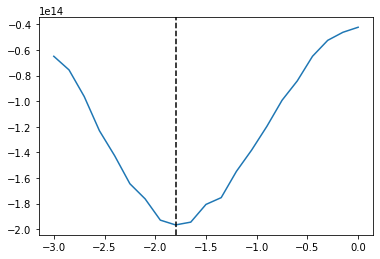

-1.7999999999999998

In [33]:
drag_calib_sweep_values = []
for i in range(len(drag_calib_sweep_results.results)):
    drag_calib_sweep_values.append(drag_calib_sweep_results.get_memory(i)[qubit])

drag_calib_sweep_values=np.real(drag_calib_sweep_values)
drag_calib_sweep_values_reshaped=drag_calib_sweep_values.reshape(len(beta_coeffs), len(n_pulses))
beta_amp= beta_coeffs[np.argmin(np.mean(drag_calib_sweep_values_reshaped, axis=-1))]

plt.pcolormesh(beta_coeffs, n_pulses, drag_calib_sweep_values_reshaped.T)
plt.axvline(x=beta_amp, ls='--', color='grey')
plt.show()

plt.plot(beta_coeffs, np.mean(drag_calib_sweep_values_reshaped, axis=-1))
plt.axvline(x=beta_amp, ls='--', color='black')
plt.show()
beta_amp

### Defining gates

Now, using the optimal $\pi$-pulse parameters we can define the $X$, $Y$, and $H$ gates.

In [ ]:
with pulse.build(name='X',backend=backend) as x_pulse:
    pulse.play(pulse.Drag(get_closest_multiple_of_16(pi_pulse_duration//dt), pi_amp_fine, sigma=get_closest_multiple_of_16(pi_pulse_width//dt), beta=beta_amp), drive_chan)

with pulse.build(name='Y',backend=backend) as y_pulse:
    # context
    pulse.shift_phase(np.pi, drive_chan)
    pulse.play(pulse.Drag(get_closest_multiple_of_16(pi_pulse_duration//dt), pi_amp_fine, sigma=get_closest_multiple_of_16(pi_pulse_width//dt), beta=beta_amp), drive_chan)    

with pulse.build(name='H',backend=backend) as h_pulse:
    # pulse context
    pulse.shift_phase(np.pi/2, drive_chan)
    pulse.play(pulse.Drag(get_closest_multiple_of_16(pi_pulse_duration//dt), pi_amp_fine/2, sigma=get_closest_multiple_of_16(pi_pulse_width//dt), beta=beta_amp), drive_chan)
    # pulse context
    pulse.shift_phase(np.pi/2, drive_chan)  

### Randomized benchmarking

Now, let's quantify the fidelity of our calibrated gates using randomized benchmarking (RB).

In [ ]:
from qiskit import QuantumCircuit
import qiskit.ignis.verification.randomized_benchmarking as rb
import qiskit.circuit.library as circuits

circ = QuantumCircuit(1,1)

circ.add_calibration('x', [qubit], x_pulse)
circ.add_calibration('h', [qubit], h_pulse)

In [48]:
circuits.XGate()

Instruction(name='x', num_qubits=1, num_clbits=0, params=[])

In [50]:
rb_opts = {}
#Number of Cliffords in the sequence
rb_opts['length_vector'] = np.arange(2,201,10)
# Number of seeds (random sequences)
rb_opts['nseeds'] = 10
# Default pattern
rb_opts['rb_pattern'] = [[qubit]]
#rb_opts['interleaved_elem']=[circuits.XGate(), circuits.HGate(), circuits.YGate()]

rb_circs, xdata = rb.randomized_benchmarking_seq(**rb_opts)

In [40]:
for circs in rb_circs:
    for circ in circs:
        circ.add_calibration('x', [qubit], x_pulse)
        circ.add_calibration('y', [qubit], y_pulse)
        circ.add_calibration('h', [qubit], h_pulse)

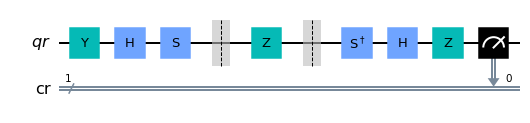

In [55]:
rb_circs[0][0].draw()

In [58]:
from qiskit.scheduler import schedule_circuit
from qiskit.compiler import schedule
schedule(rb_circs[0][0], backend=backend)

Traceback (most recent call last):
  File "/tmp/ipykernel_59/3719971512.py", line 3, in <module>
    schedule(rb_circs[0][0], backend=backend)
  File "/opt/conda/lib/python3.8/site-packages/qiskit/compiler/scheduler.py", line 100, in schedule
    schedules = [schedule_circuit(circuit, schedule_config, method) for circuit in circuits]
  File "/opt/conda/lib/python3.8/site-packages/qiskit/compiler/scheduler.py", line 100, in <listcomp>
    schedules = [schedule_circuit(circuit, schedule_config, method) for circuit in circuits]
  File "/opt/conda/lib/python3.8/site-packages/qiskit/scheduler/schedule_circuit.py", line 59, in schedule_circuit
    return methods[method](circuit, schedule_config)
  File "/opt/conda/lib/python3.8/site-packages/qiskit/scheduler/methods/basic.py", line 103, in as_late_as_possible
    circ_pulse_defs = lower_gates(circuit, schedule_config)
  File "/opt/conda/lib/python3.8/site-packages/qiskit/scheduler/lowering.py", line 163, in lower_gates
    raise QiskitError(

In [51]:
shots=1024
gate_rb = assemble([circ for circ in circs for circs in rb_circs], 
                   backend=backend,
                   shots=shots)

job_gate_rb = backend.run(gate_rb)
job_monitor(job_gate_rb)

Job Status: job incurred error    


In [ ]:
#inst_sched_map.add(gate)